# Import libraries

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


# General analysis of the dataset

In [326]:
autos_df = pd.read_csv("assets/autos.csv")

# First, we'll start by analizing the macros of the dataset.
print(autos_df.info())
print(autos_df.describe())
print(autos_df.isnull().sum())

# We notice some rare things:
# 1. The max year is 5008.
# 2. The max km is 1e11.
# 3. The min age is -2984.
# 4. The min price tag is 1 and the max is 1e11.
# There is no record with NaN in an important column (price and make_id)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make_id            19999 non-null  object 
 1   model_id           19998 non-null  float64
 2   year               19999 non-null  int64  
 3   cylinder_capacity  14757 non-null  float64
 4   km                 19999 non-null  int64  
 5   color              3438 non-null   object 
 6   region             19977 non-null  object 
 7   price              19999 non-null  int64  
 8   fuel_type_id       19980 non-null  object 
 9   transmission_id    19998 non-null  object 
 10  traction_id        10771 non-null  float64
 11  age                19999 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.8+ MB
None
           model_id          year  cylinder_capacity            km  \
count  19998.000000  19999.000000       14757.000000  1.999900e+04   
mean    1318

## Dataset cleanse

1. For the "year" column, asume that any year value above the current year is a typo error, so the first digit will be replaced with a "2". Also, any year below 1900 will be set to that value.
2. For the "km" case asume that the seller intention was to indicate that the car was extremely used, so set any value above 100.000.000 to that value.
3. For the "age" column, replace the entire column content by the difference between the current year 2024 and the "year" value.
4. For the "price" column, given that the prediction of prices is the main goal of this test, consider the price tag a special value, thus applying a more dramatic approach: remove any record with the maximum price tag 1e11 and any price tag below 100.000.
5. Delete any record for which their "make_id" is a non-integer.

In [327]:
def correct_year(year):
    if year > 2024:
        year = int("2" + str(year)[1:])
    if year < 1900:
        return 1900
    return year

def correct_km(km, threshold=100000000):
    if km > threshold:
        return threshold
    return km

autos_df["year"] = autos_df["year"].apply(correct_year)
autos_df["km"] = autos_df["km"].apply(correct_km)
autos_df["age"] = 2024 - autos_df["year"]
autos_df = autos_df[(autos_df["price"] < 1e10) & (autos_df["price"] >= 100000)]
autos_df["make_id"] = pd.to_numeric(autos_df["make_id"], errors="coerce")
autos_df = autos_df.dropna(subset=["make_id"])
print(autos_df.info()) #reduced 2% of records.
print(autos_df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 19585 entries, 0 to 19998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make_id            19585 non-null  float64
 1   model_id           19585 non-null  float64
 2   year               19585 non-null  int64  
 3   cylinder_capacity  14444 non-null  float64
 4   km                 19585 non-null  int64  
 5   color              3351 non-null   object 
 6   region             19563 non-null  object 
 7   price              19585 non-null  int64  
 8   fuel_type_id       19566 non-null  object 
 9   transmission_id    19584 non-null  object 
 10  traction_id        10547 non-null  float64
 11  age                19585 non-null  int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 1.9+ MB
None
            make_id      model_id          year  cylinder_capacity  \
count  19585.000000  19585.000000  19585.000000       14444.000000   
mean      39.1922

## Plot car prices distribution
Adjust to logistic values to plot properly

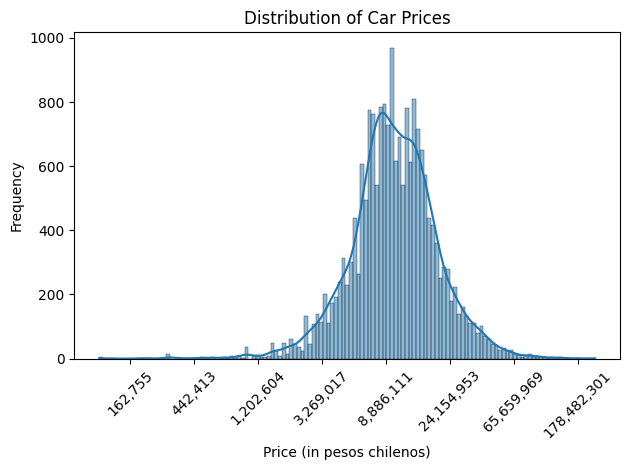

In [328]:
sns.histplot(np.log(autos_df["price"]), kde=True)
plt.title("Distribution of Car Prices")

ax = plt.gca()
ticks = ax.get_xticks()
tick_labels = [f"{np.exp(tick):,.0f}" for tick in ticks]
ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.set_xticklabels(tick_labels, rotation=45)
plt.xlabel("Price (in pesos chilenos)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Data Preparation

### 1. Fix dataset region column
Generate a region dictionary to normalize values, then factorize the result.

Records with no region will receive a -1 as value.

In [329]:
keyword_to_region = {
    "valparaíso": "V Valparaíso",
    "metropolitana": "XIII Metropolitana de Santiago",
    "biobío": "VIII Biobío",
    "bío bío": "VIII Biobío",
    "maule": "VII Maule",
    "araucanía": "IX Araucanía",
    "los lagos": "X Los Lagos",
    "coquimbo": "IV Coquimbo",
    "ohiggins": "VI O'Higgins",
    "o'higgins": "VI O'Higgins",
    "ñuble": "XVI Ñuble",
    "antofagasta": "II Antofagasta",
    "magallanes": "XII Magallanes & Antártica",
    "los ríos": "XIV Los Ríos",
    "atacama": "III Atacama",
    "tarapacá": "I Tarapacá",
    "aysén": "XI Aisén",
    "aisén": "XI Aisén",
    "arica": "XV Arica & Parinacota",
}

def standardize_region_by_keyword(name):
    for keyword, standardized_name in keyword_to_region.items():
        if keyword in str(name).lower():
            return standardized_name
    return name

autos_df["region"] = autos_df["region"].apply(standardize_region_by_keyword)
codes, uniques = pd.factorize(autos_df["region"])
autos_df["region"] = codes
region_mapping = {code: region for code, region in enumerate(uniques)}
print(autos_df["region"].unique())


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 -1 13 14 15]


### 2. Transform make_id and model_id float columns into int directly.
### 3. Transform colors categorical data into numeric format.
Records with no color will receive a -1 as value.
### 4. Transform traction_id float column into int and fill empty values.

In [330]:
autos_df["make_id"] = autos_df["make_id"].astype(int)
autos_df["model_id"] = autos_df["model_id"].astype(int)
codes, uniques = pd.factorize(autos_df["color"])
autos_df["color"] = codes
color_mapping = {code: color for code, color in enumerate(uniques)}
autos_df["traction_id"] = autos_df["traction_id"].fillna(-1).astype(int)

print(autos_df["color"].unique(), autos_df["color"].describe())
print(autos_df["traction_id"].unique(), autos_df["traction_id"].describe())

[ 0 -1  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] count    19585.000000
mean        -0.294715
std          2.104147
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max         21.000000
Name: color, dtype: float64
[ 0 -1  1] count    19585.000000
mean        -0.291652
std          0.739099
min         -1.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: traction_id, dtype: float64


### 5. Transform fuel_type_id and transmission_id into numeric format
Records with no fuel_type_id or transmission_id will be deleted since there are only 20 and 2, respectively.

In [331]:
autos_df["fuel_type_id"] = pd.to_numeric(autos_df["fuel_type_id"], errors="coerce")
autos_df = autos_df.dropna(subset=["fuel_type_id"])
autos_df["fuel_type_id"] = autos_df["fuel_type_id"].astype(int)


autos_df["transmission_id"] = pd.to_numeric(
  autos_df["transmission_id"].astype(str), errors="coerce")
autos_df = autos_df.dropna(subset=["transmission_id"])
autos_df["transmission_id"] = autos_df["transmission_id"].astype(int)

print(autos_df["fuel_type_id"].unique(), autos_df["fuel_type_id"].describe())
print(autos_df["transmission_id"].unique(), autos_df["transmission_id"].describe())

[1 0 2 3] count    19566.000000
mean         0.245784
std          0.447101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: fuel_type_id, dtype: float64
[0 1] count    19566.000000
mean         0.408004
std          0.491476
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: transmission_id, dtype: float64



### 6. Transform cylinder_capacity into an int
NaN values will be considered 0s.

In [332]:
autos_df["cylinder_capacity"] = autos_df["cylinder_capacity"].fillna(0)
autos_df["cylinder_capacity"] = autos_df["cylinder_capacity"].astype(int)
print(autos_df["cylinder_capacity"].unique(), autos_df["cylinder_capacity"].describe())


[ 1600  1500  2500  1800     0  1400  2200  2000  2400  1200  1300  3500
  9000  3000  3600  2800  5000  3200  4000  7000  6000  1000  3900  1100
  6700  5700  5300  2300  3700   800  3300  3800  7100   900  1700  7900
  2900  5900  2100  2600  1900  5400  6900  8000  4200  7400  5500  4800
  8500  4100  2700  7600  9400  3100  9800  4300   700  4400  3400  6600
   400  7200  8400  9600  4700  4500  6800   500  6200   200  6500  8900
  4600  7300  4900  5800  5600  7500  9500  6100  9300  8200  8700 24000
  5200  9200   300  8100  9900  6300  9700  6400  8800  8300  7800] count    19566.000000
mean      1533.731984
std       1325.420279
min          0.000000
25%          0.000000
50%       1600.000000
75%       2000.000000
max      24000.000000
Name: cylinder_capacity, dtype: float64


## [Optional] Save the cleaned dataset as a new .csv file

In [333]:
autos_df.to_csv("assets/cleaned_autos.csv", index=False)


# Separate dataset in training and testing

In [335]:
autos_X = autos_df.drop(["price"], axis=1)
autos_y = autos_df["price"]
X_train, X_test, y_train, y_test = train_test_split(
  autos_X, autos_y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} records")
print(f"Testing set size: {X_test.shape[0]} records")


Training set size: 15652 records
Testing set size: 3914 records



# Train, test and plot multiple sklearn models
Try several sklearn models.

Use RMSE and R2 as metrics to decide which models to continue tunning.

RMSE allows to measure the magnitude of errors, which can be intuitive to interpret since its unit is the same as the measured variable.

R2 indicates how the model fits to predict the target variable.

Linear Regression:
  RMSE: 8968653.000951663
  R²: 0.29808867846316744



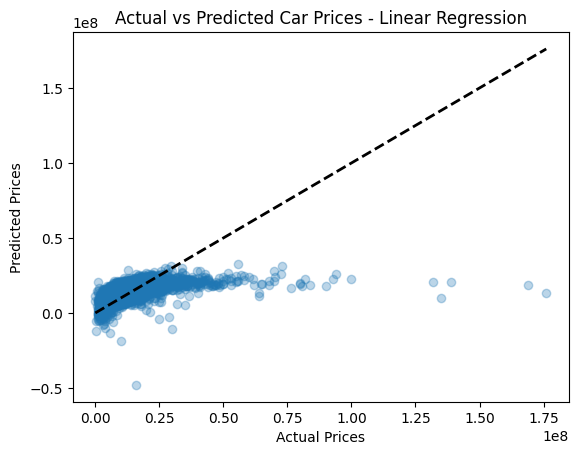

Ridge Regression:
  RMSE: 8968624.309428237
  R²: 0.2980931694102269



/home/enzobh/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.97441e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


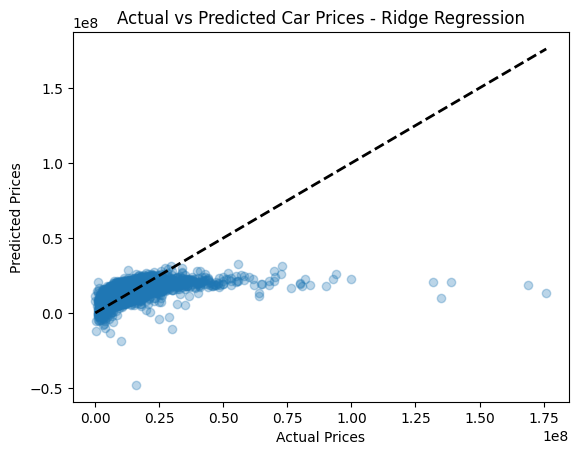

Random Forest:
  RMSE: 6352881.358719046
  R²: 0.6478162654294363



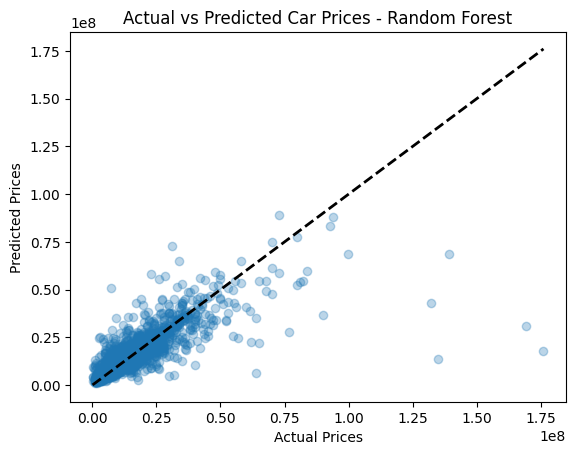

Gradient Boosting:
  RMSE: 6756182.08568291
  R²: 0.6016814832108908



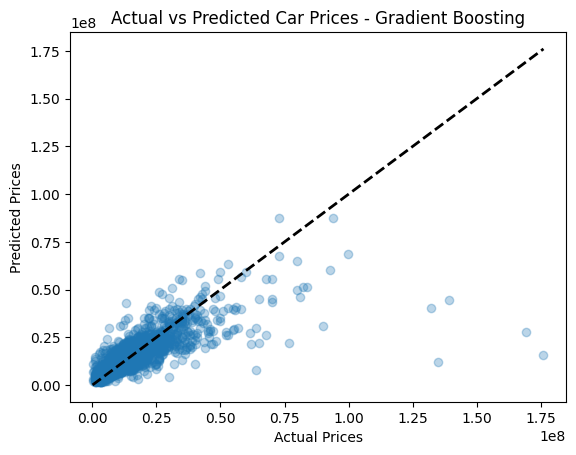

Support Vector Regression:
  RMSE: 11004799.572984425
  R²: -0.05679823492829206



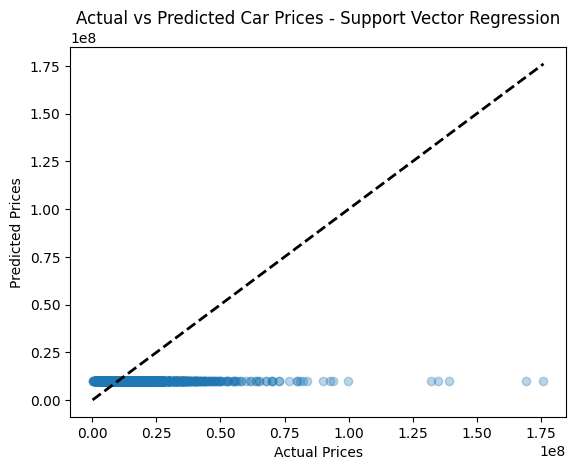

Decision Tree:
  RMSE: 8041806.310407829
  R²: 0.435667551826616



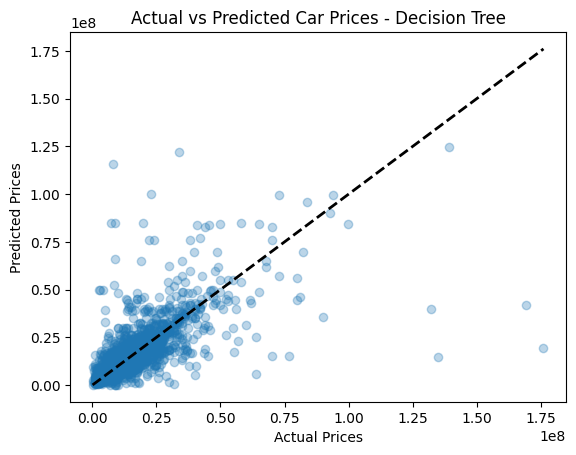

In [341]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
    ("Support Vector Regression", SVR()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42))
]

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name}:")
    print(f"  RMSE: {rmse}")
    print(f"  R²: {r2}\n")
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.xlabel("Actual Prices")
    plt.ylabel("Predicted Prices")
    plt.title(f"Actual vs Predicted Car Prices - {name}")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()


### The best models in terms of R2 and RMSE are random forest and gradient boosting.
Now the iterating will continue over those models

### 1. Iterate over different training/testing sizes

In [344]:
models = [
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("Gradient Boosting", GradientBoostingRegressor(random_state=42)),
]
test_sizes = [0.15, 0.2, 0.25, 0.3]
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(autos_X, autos_y, test_size=test_size, random_state=42)

    print(f"\nTest size: {test_size}")
    print("----------------------------")
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{name}:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²: {r2:.4f}")



Test size: 0.15
----------------------------
Random Forest:
  RMSE: 6794061.9576
  R²: 0.6400
Gradient Boosting:
  RMSE: 7323344.9743
  R²: 0.5817

Test size: 0.2
----------------------------
Random Forest:
  RMSE: 6352881.3587
  R²: 0.6478
Gradient Boosting:
  RMSE: 6756182.0857
  R²: 0.6017

Test size: 0.25
----------------------------
Random Forest:
  RMSE: 6397295.4612
  R²: 0.6488
Gradient Boosting:
  RMSE: 6673233.0379
  R²: 0.6178

Test size: 0.3
----------------------------
Random Forest:
  RMSE: 6292014.6790
  R²: 0.6486
Gradient Boosting:
  RMSE: 6421365.1479
  R²: 0.6340


### Considering that the RMSE diminishes considerable between test size 0.25 to 0.3, the best training size is 0.70.
Now the iteration will continue with the hyperparameter for these models and the found training size

### 2. Iterate over different hyperparameters
Using GridSearchCV already incorporates cross-validation

In [352]:
X_train, X_test, y_train, y_test = train_test_split(
    autos_X, autos_y, test_size=0.3, random_state=42
)

random_forest_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}

gradient_boosting_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5]
}

print("Tuning Random Forest.")
rf_model = GridSearchCV(
  RandomForestRegressor(random_state=42), random_forest_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
rf_model.fit(X_train, y_train)
print("Best parameters for Random Forest:", rf_model.best_params_)
print(f"Best cross-validation R² (Random Forest): {rf_model.best_score_:.4f}")
rf_best = rf_model.best_estimator_
rf_pred = rf_best.predict(X_test)
print(f"Test RMSE (Random Forest): {np.sqrt(mean_squared_error(y_test, rf_pred)):.4f}")
print(f"Test R² (Random Forest): {r2_score(y_test, rf_pred):.4f}\n")

print("Tuning Gradient Boosting...")
gb_model = GridSearchCV(GradientBoostingRegressor(
  random_state=42), gradient_boosting_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
gb_model.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", gb_model.best_params_)
print(f"Best cross-validation R² (Gradient Boosting): {gb_model.best_score_:.4f}")
gb_best = gb_model.best_estimator_
gb_pred = gb_best.predict(X_test)
print(f"Test RMSE (Gradient Boosting): {np.sqrt(mean_squared_error(y_test, gb_pred)):.4f}")
print(f"Test R² (Gradient Boosting): {r2_score(y_test, gb_pred):.4f}")


Tuning Random Forest.
Fitting 5 folds for each of 6 candidates, totalling 30 fits


Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Best cross-validation R² (Random Forest): 0.6568
Test RMSE (Random Forest): 6252285.7938

Test R² (Random Forest): 0.6530

Tuning Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation R² (Gradient Boosting): 0.7453
Test RMSE (Random Forest): 5570232.7554

Test R² (Gradient Boosting): 0.7246


## So far, our best model consists of the following:
Results: RMSE=5570232.7554 and R2=0.7246.

Train size of 0.70%.

Gradient Boosting model with parameters learning_rate=0.1, max_depth=5, n_estimators=200.

## Lastly, drop columns and check of RMSE or R2 presents better results without any column.

In [351]:
original_features = autos_X.columns.tolist()
model_performance = {}
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
for column_to_drop in original_features:
    X_modified = autos_X.drop([column_to_drop], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(
        X_modified, autos_y, test_size=0.30, random_state=42
    )
    model = GradientBoostingRegressor(**best_params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    model_performance[column_to_drop] = {'RMSE': rmse, 'R2': r2}
for column, metrics in model_performance.items():
    print(f"Performance without '{column}': RMSE = {metrics['RMSE']:.4f}, R² = {metrics['R2']:.4f}")


Performance without 'make_id': RMSE = 5933414.5054, R² = 0.6875
Performance without 'model_id': RMSE = 5959518.6049, R² = 0.6848
Performance without 'year': RMSE = 5580002.3075, R² = 0.7236
Performance without 'cylinder_capacity': RMSE = 5602603.7895, R² = 0.7214
Performance without 'km': RMSE = 5630931.6581, R² = 0.7186
Performance without 'color': RMSE = 5509795.5299, R² = 0.7306
Performance without 'region': RMSE = 5596186.7718, R² = 0.7220
Performance without 'fuel_type_id': RMSE = 5517019.6261, R² = 0.7299
Performance without 'transmission_id': RMSE = 5721600.3146, R² = 0.7094
Performance without 'traction_id': RMSE = 5580293.8121, R² = 0.7236
Performance without 'age': RMSE = 5570283.0413, R² = 0.7246


### From the results, we notice that removing two columns enhance the results: color and fuel_type_id
In the context we are analyzing data (vehicles pricing related to the car characteristics) I consder the fuel type to be extremely important, thus it can not be removed from the dataset.
In contrast, the color might not be so determinant regarding a car purchase, so we will remove this column from the dataset to generate our final model.

In [353]:
autos_X_final = autos_X.drop(['color'], axis=1)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    autos_X_final, autos_y, test_size=0.30, random_state=42
)
final_model = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=200, random_state=42)
final_model.fit(X_train_final, y_train_final)
y_pred_final = final_model.predict(X_test_final)
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))
r2_final = r2_score(y_test_final, y_pred_final)
print(f"Final RMSE: {rmse_final:.4f}")
print(f"Final R²: {r2_final:.4f}")


Final RMSE: 5509795.5299
Final R²: 0.7306


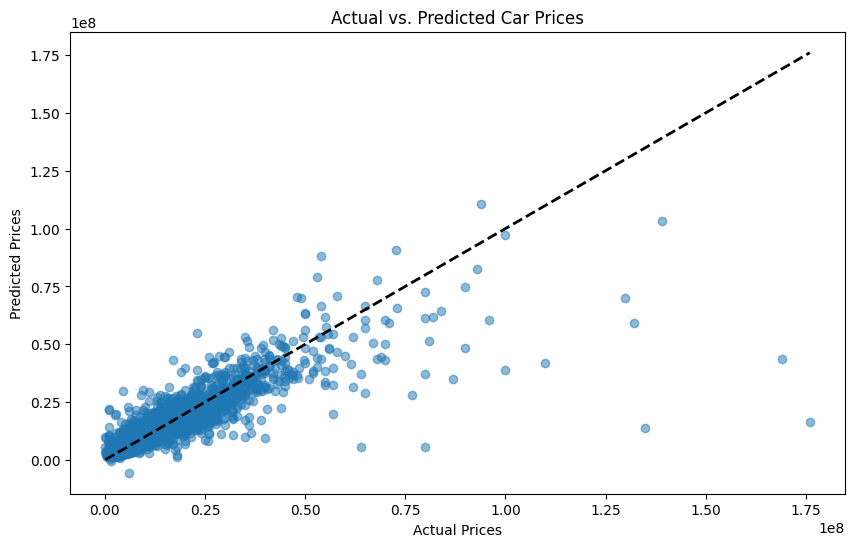

In [354]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_final, y_pred_final, alpha=0.5)
plt.plot([y_test_final.min(), y_test_final.max()], [y_test_final.min(), y_test_final.max()], 'k--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Car Prices')
plt.show()

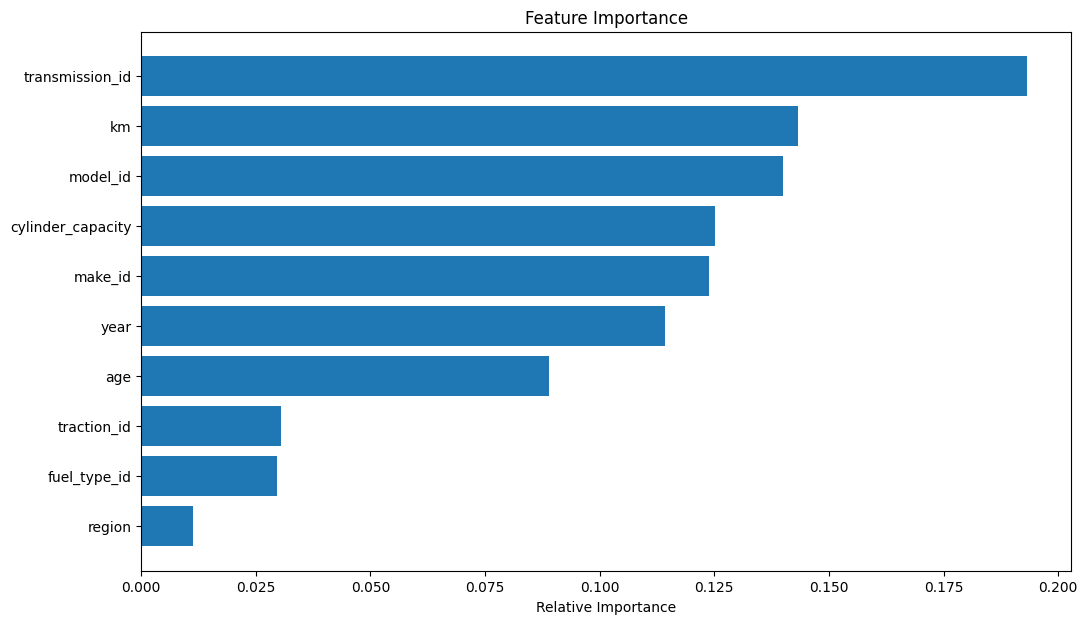

In [356]:
feature_importance = final_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12, 7))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(autos_X_final.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()
